In [1]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error 
from sklearn.linear_model import Lasso, Ridge, RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
import scipy.io as sio
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
subject = "zarya"
date = "20250411"

base_path = "/Users/j1155665/Desktop/Chris lab/Data Analysis"
file_name = f"@neural_{subject}/{subject}{date}dots3DMP.mat"
matfile_path = os.path.join(base_path, file_name)

responsive_units = np.load("20250411_responsive_unit.npy")
selective_units = np.load("20250411_selective_unit.npy")

try:
    mat_data = sio.loadmat(matfile_path)
    
    if 'dataStruct' in mat_data and 'data' in mat_data['dataStruct'].dtype.names:
        dataStruct = mat_data['dataStruct'][0, 0]       
        data_field = dataStruct['data'][0, 0]          
        data = data_field['dots3DMP'][0, 0] 
        events = data['events'][0, 0]
        unit = data['unit'][0, 0]
#         data_spkrate = data['data_spkrate'][0,0]
        data_spkrate = data['data_spkrate']
        depth = unit['depth'].flatten().reshape(-1, 1)
        cluster_id = unit['cluster_id'].flatten().reshape(-1, 1)
        stimOn_spkrate = data_spkrate['stimOn']
        saccOnset_spkrate = data_spkrate['saccOnset']
        postTargHold_spkrate = data_spkrate['postTargHold']
        choice = events['choice'].flatten().reshape(-1, 1)
        PDW = events['PDW'].flatten().reshape(-1, 1)
        headingInd = events['headingInd'].flatten().reshape(-1, 1)
        modality = events['modality'].flatten().reshape(-1, 1)
        coherence = events['coherenceInd'].flatten().reshape(-1, 1)
        
        
        print("Data loaded successfully.")
    else:
        print("Error: 'dataStruct.data' not found in the .mat file.")
        
except FileNotFoundError:
    print(f"Error: The file {matfile_path} was not found.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Data loaded successfully.


In [3]:
event_info = {
    "modality": ["vestibular", "visual", "combined"],
    "coherence": [0.2, 0.7],
    "heading_angle": [-10, -3.9, -1.5, 0, 1.5, 3.9, 10],
    "stimulus": ["left", "right"],
    "choice": ["left", "right"],
    "confidence": ["low bet", "high bet"],
    "name": ["modality", "coherenceInd", "headingInd", "choice", "PDW"],
    "class_1": [None, None, [1,2,3], 1, 0],
    "class_2": [None, None, [7,6,5], 2, 1]
}

time_info = {
    "offset": 0.05,  # ms
    "bin_size": 0.02,  # ms
    "align_event": ["stimOn", "saccOnset", "postTargHold"],
    "center_start": [-0.1, -0.8, -0.3],
    "center_stop": [0.8, 0.1, 0.1],
}

tunning_info = {
    "offset": 0.05,  # ms
    "bin_size": 0.02,  # ms
    "align_event": "stimOn",
    "center_start": -0.5,
    "center_stop": 0.5,
}


In [4]:
## Recording Info

# 20250501
depth_ranges = [
    (0, 900),          # below MST
    (1000, 3080),      # MST
    (3900, 6460)     # VPS
]

depth_labels = [
    "0–900 μm (below MST)",
    "1000–3080 μm (MST)",
    "3900–6460 μm (VPS)"
]

# 20250306
# depth_ranges = [
#     (0, 1300),          # below MST
#     (1300, 3180),      # MST
#     (3900, 7460),     # VPS
#     (7660, np.max(depth)) # above VPS
# ]

# depth_labels = [
#     "0–1300 μm (below MST)",
#     "1300–3180 μm (MST)",
#     "3900–7460 μm (VPS)"
# #     "7660 - μm (above VPS)"
# ]

############# PLD Info#############
spkrates = [stimOn_spkrate, saccOnset_spkrate, postTargHold_spkrate]
event_names = ['stimOn', 'Choice', 'PDW']



mods = [1, 2, 2, 3, 3]
cohs = [1, 1, 2, 1, 2]

mod_names = [
    "vestibular", 
    "visual, low coh",
    "visual, high coh",
    "combine, low coh",
    "combine, high coh"
]

heading_angles = np.array(event_info["heading_angle"])
tuning_angles = np.array([-45, -21.5, -10, -3.9, 3.9, 10, 21.5, 45])

In [5]:
def log_decoder(X, y, time_info, valid_trials, valid_cluster, dualratio=1, 
                event_info=None, target_name=None,
                valid_cluster_2=None, n_shuffles=0,
                align_event=0, num_units=50, n_splits=10, 
                num_repeats=5, return_coef=False):

    # Time info
    center_start = time_info["center_start"][align_event]
    center_stop = time_info["center_stop"][align_event]
    bin_size = time_info["bin_size"]
    time_axis = np.arange(center_start, center_stop + bin_size, bin_size) * 1000  # in ms

    # Update labels based on event_info and target_name if provided
    if event_info is not None and target_name is not None:
        target_idx = event_info["name"].index(target_name)
        class_1 = event_info["class_1"][target_idx]
        class_2 = event_info["class_2"][target_idx]

        # Ensure class_1 and class_2 are iterable
        if class_1 is not None and class_2 is not None:
            if not isinstance(class_1, (list, tuple)):
                class_1 = [class_1]
            if not isinstance(class_2, (list, tuple)):
                class_2 = [class_2]
            y = np.array([0 if v in class_1 else 1 if v in class_2 else np.nan for v in y])
        else:
            raise ValueError(f"target, {target_name} must have both class_1 and class_2 defined in event_info")
    
    if dualratio == 1:
        if num_units == 0:
            num_units = len(valid_cluster)
            num_repeats = 1

    all_mean_scores = []
    all_std_scores = []
    shuffle_scores_all = []

    clf = LogisticRegression(penalty='l1', C = 10, solver='liblinear', max_iter=3000)
#     clf = SVC(kernel='rbf', C=1, probability=True) 
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # No condition masking, just select valid trials
    selected_trials = ~np.isnan(y).flatten() & valid_trials.flatten()
    X_clean = X[0, 0][selected_trials]
    y_clean = y[selected_trials].flatten()
    
    X_clean = np.array(X_clean)

    invalid_idx = []

    for i in range(X_clean.shape[0]): 
        for j in range(X_clean.shape[1]):  
            try:
                if np.isnan(X_clean[i, j][0][0]):
                    invalid_idx.append(i)
                    break
            except IndexError:
                print(f"IndexError at X_sub[{i}, {j}] — skipping")
            except TypeError:
                print(f"TypeError at X_sub[{i}, {j}] — not array-like")

    invalid_idx = np.array(invalid_idx, dtype=int)
    valid_mask = np.ones(X_clean.shape[0], dtype=bool)
    valid_mask[invalid_idx] = False
    if not valid_mask.all():
        X_clean = X_clean[valid_mask, :]         
        y_clean = y_clean[valid_mask]       

    num_events, num_units_total = X_clean.shape
    num_time_points = X_clean[0, 0][0].shape[0]
    

    for rep in range(num_repeats):
        if len(valid_cluster) < num_units:
            raise ValueError(f"Not enough valid units ({len(valid_cluster)}) to sample {num_units}")

        if num_units == 0:
            selected_units = valid_cluster
        else:
            if valid_cluster_2 is not None:
                unit_A = round(num_units * dualratio)
                unit_B = num_units - unit_A

                if len(valid_cluster) < unit_A:
                    raise ValueError(f"Not enough units in valid_cluster to sample {unit_A}")
                if len(valid_cluster_2) < unit_B:
                    raise ValueError(f"Not enough units in valid_cluster_2 to sample {unit_B}")

                selected_units_A = np.random.choice(valid_cluster, size=unit_A, replace=False)
                selected_units_B = np.random.choice(valid_cluster_2, size=unit_B, replace=False)
                selected_units = np.concatenate([selected_units_A, selected_units_B])
            else:
                if len(valid_cluster) < num_units:
                    raise ValueError(f"Not enough units in valid_cluster to sample {num_units}")
                selected_units = np.random.choice(valid_cluster, size=num_units, replace=False) 
                
        X_sub = np.array(X_clean[:, selected_units])
        
        mean_scores = []
        std_scores = []
        shuffle_scores = []

        for t in range(num_time_points):
            X_input = [[X_sub[i, j][0][t] for j in range(num_units)] for i in range(len(X_sub))]
#             scaler = StandardScaler()         
#             X_input = scaler.fit_transform(X_input)
            
            y_input = y_clean
            scores = cross_val_score(clf, X_input, y_input, cv=skf)
            mean_scores.append(scores.mean())
            std_scores.append(scores.std())
            
            # Null decoding by shuffling labels
            if n_shuffles > 0:
                shuf_scores = []
                for _ in range(n_shuffles):
                    y_shuffled = np.random.permutation(y_input)
                    null_score = cross_val_score(clf, X_input, y_shuffled, cv=skf).mean()
                    shuf_scores.append(null_score)
                shuffle_scores.append(shuf_scores)

        all_mean_scores.append(mean_scores)
        all_std_scores.append(std_scores)
        if n_shuffles > 0:
            shuffle_scores_all.append(shuffle_scores)

    mean_scores_avg = np.mean(all_mean_scores, axis=0)
    sem_scores = np.std(all_mean_scores, axis=0) / np.sqrt(len(all_mean_scores))
    if n_shuffles > 0:
        shuffle_scores_all = np.array(shuffle_scores_all)
        null_mean = shuffle_scores_all.mean(axis=(0, 2)) 
    

    if n_shuffles > 0:
        return mean_scores_avg, sem_scores, time_axis, null_mean
    else:
        return mean_scores_avg, sem_scores, time_axis


Total valid units under vestibular: 108, 79
Total trial for vestibular: 135
Total valid units under visual, low coh: 85, 70
Total trial for visual, low coh: 132
Total valid units under visual, high coh: 85, 70
Total trial for visual, high coh: 120
Total valid units under combine, low coh: 90, 68
Total trial for combine, low coh: 153
Total valid units under combine, high coh: 90, 68
Total trial for combine, high coh: 135


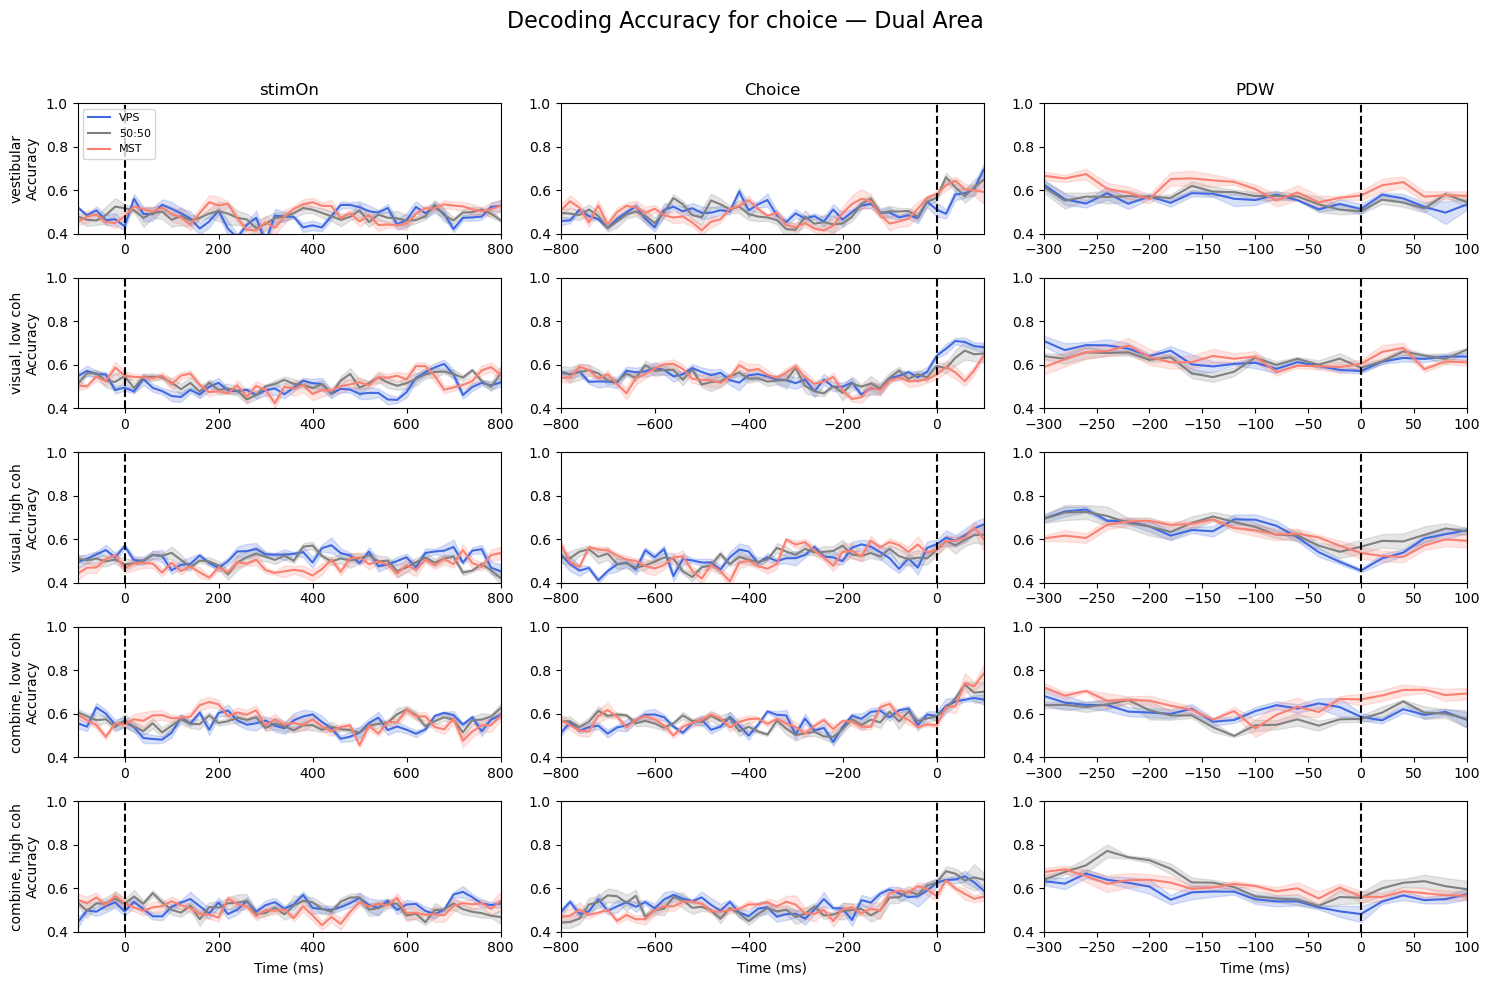

Total valid units under vestibular: 108, 79
Total trial for vestibular: 135
Total valid units under visual, low coh: 85, 70
Total trial for visual, low coh: 132
Total valid units under visual, high coh: 85, 70
Total trial for visual, high coh: 120
Total valid units under combine, low coh: 90, 68
Total trial for combine, low coh: 153
Total valid units under combine, high coh: 90, 68
Total trial for combine, high coh: 135


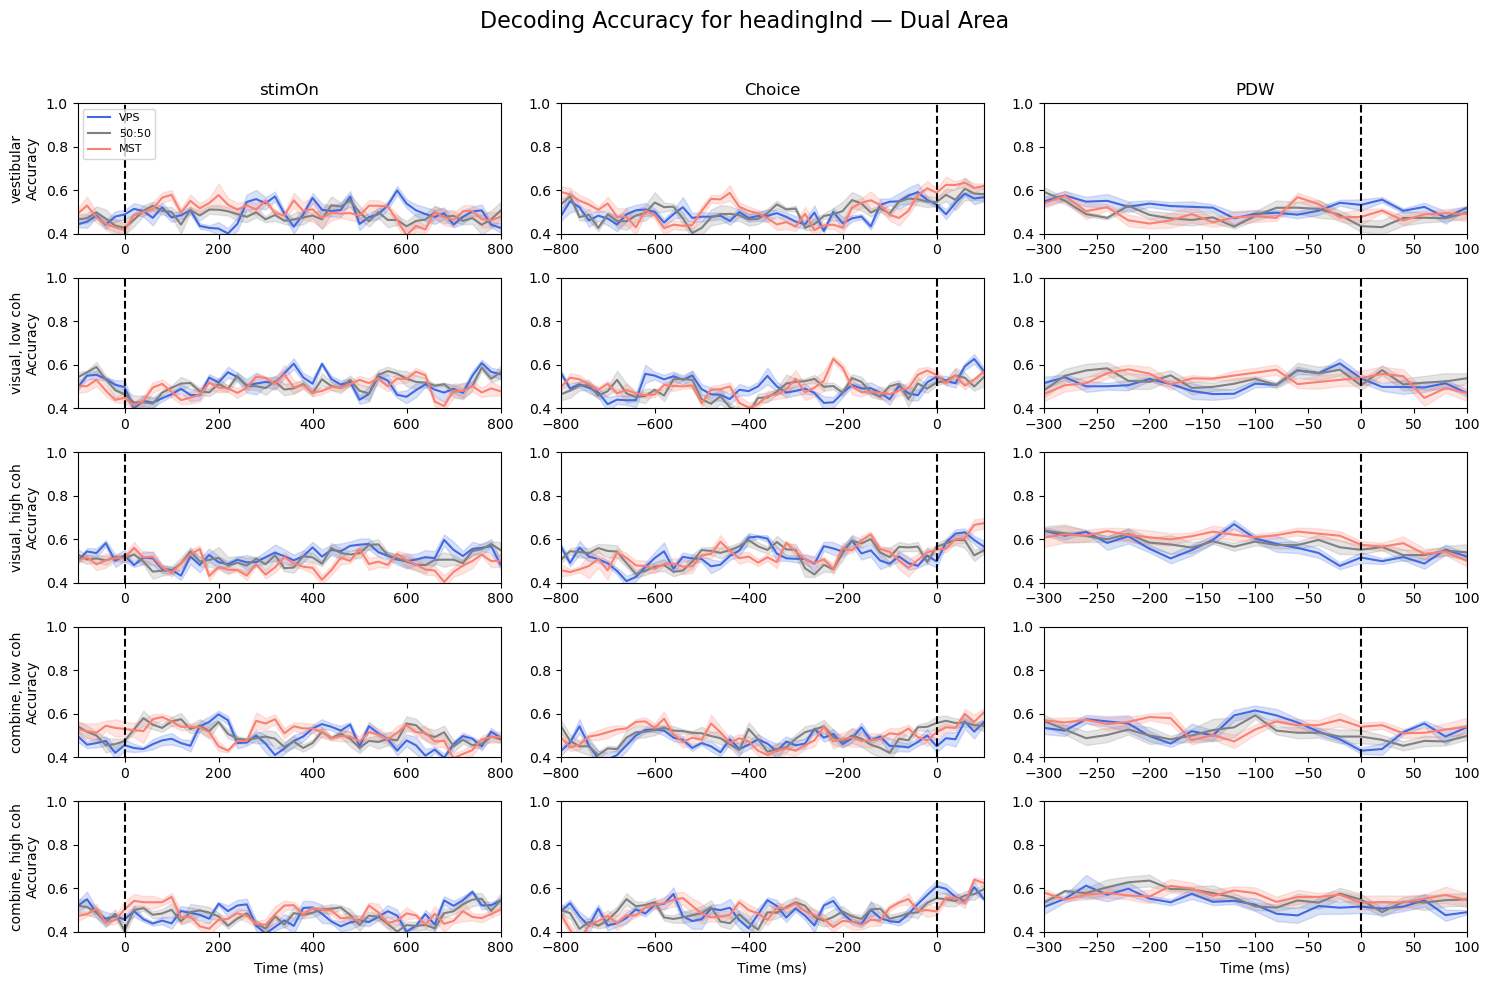

In [6]:
# Plot the decoder accuracy for the across area
# with PdfPages("20250501_dots3DMP_dualaccuracyplot.pdf") as pdf:

class_unit = responsive_units
for d, target_name, y, color in zip(
    [0, 1],
    ["choice", "headingInd"],
    [choice.copy(), headingInd.copy()],
    ["royalblue", "salmon"]
    ):

    for idx, (depth_min, depth_max) in enumerate(depth_ranges):

        if idx !=1:
            continue
            
        

        plt.figure(figsize=(15, 10))

        for modcoh in range(5):
            mod = mods[modcoh]
            coh = cohs[modcoh]
            valid_trials = (modality == mod) & (coherence == coh) # & np.isin(headingInd, [1, 7])
            valid_scores = class_unit[(mod - 1),:].reshape(-1,1)
            threshold = np.quantile(valid_scores, 0.30)

            valid_depth = (depth >= depth_min) & (depth <= depth_max) & (valid_scores <= threshold)
            valid_cluster = cluster_id[np.where(valid_depth)]

            valid_depth2 = (depth >= depth_ranges[idx+1][0]) & (depth <= depth_ranges[idx+1][1]) & (valid_scores <= threshold)
            valid_cluster_2 = cluster_id[valid_depth2]
            
            print(f"Total valid units under {mod_names[modcoh]}: {len(valid_cluster)}, {len(valid_cluster_2)}")
            print(f"Total trial for {mod_names[modcoh]}: {np.sum(valid_trials)}")

            for i in range(3):  
                X = spkrates[i].copy()

                ax = plt.subplot(5, 3, modcoh * 3 + i + 1)

                for ratio, ratio_color, area_name in zip(
                    [0, 0.5,1],
                    ["royalblue","gray", "salmon"],
                    ["VPS", "50:50", "MST"]
                    ):

                    mean_scores, sem_scores, time_axis = log_decoder(X, y, time_info, 
                        valid_trials, valid_cluster, valid_cluster_2 = valid_cluster_2,
                        dualratio = ratio, event_info=event_info, target_name=target_name,
                        align_event=i, num_units=30, n_splits=8, num_repeats=5)


                    ax.plot(time_axis[:len(mean_scores)], mean_scores, label=area_name, 
                            color=ratio_color)
                    ax.fill_between(
                        time_axis[:len(mean_scores)],
                        np.array(mean_scores) - np.array(sem_scores),
                        np.array(mean_scores) + np.array(sem_scores),
                        color=ratio_color, alpha=0.2
                    )

                ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
                ax.set_ylim(0.4, 1)
                ax.set_xlim(time_axis[0], time_axis[-1])

                if modcoh == 0:
                    ax.set_title(event_names[i])
                if modcoh == 4:
                    ax.set_xlabel("Time (ms)")
                if i == 0:
                    ax.set_ylabel(f"{mod_names[modcoh]}\nAccuracy")

                # Only add legend to the last plot of the top row (to avoid clutter)
                if modcoh == 0 and i == 0:
                    ax.legend(loc="upper left", fontsize=8)

        plt.suptitle(f"Decoding Accuracy for {target_name} — Dual Area", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
#         pdf.savefig()
#         plt.close()
        plt.show()


Number of valid trials: 26
Using n_splits = 8 for cross-validation.
Total valid units under vestibular: 58
Number of valid trials: 25
Using n_splits = 8 for cross-validation.
Total valid units under visual, low coh: 58
Number of valid trials: 26
Using n_splits = 8 for cross-validation.
Total valid units under visual, high coh: 58
Number of valid trials: 26
Using n_splits = 8 for cross-validation.
Total valid units under combine, low coh: 232
Number of valid trials: 26
Using n_splits = 8 for cross-validation.
Total valid units under combine, high coh: 232


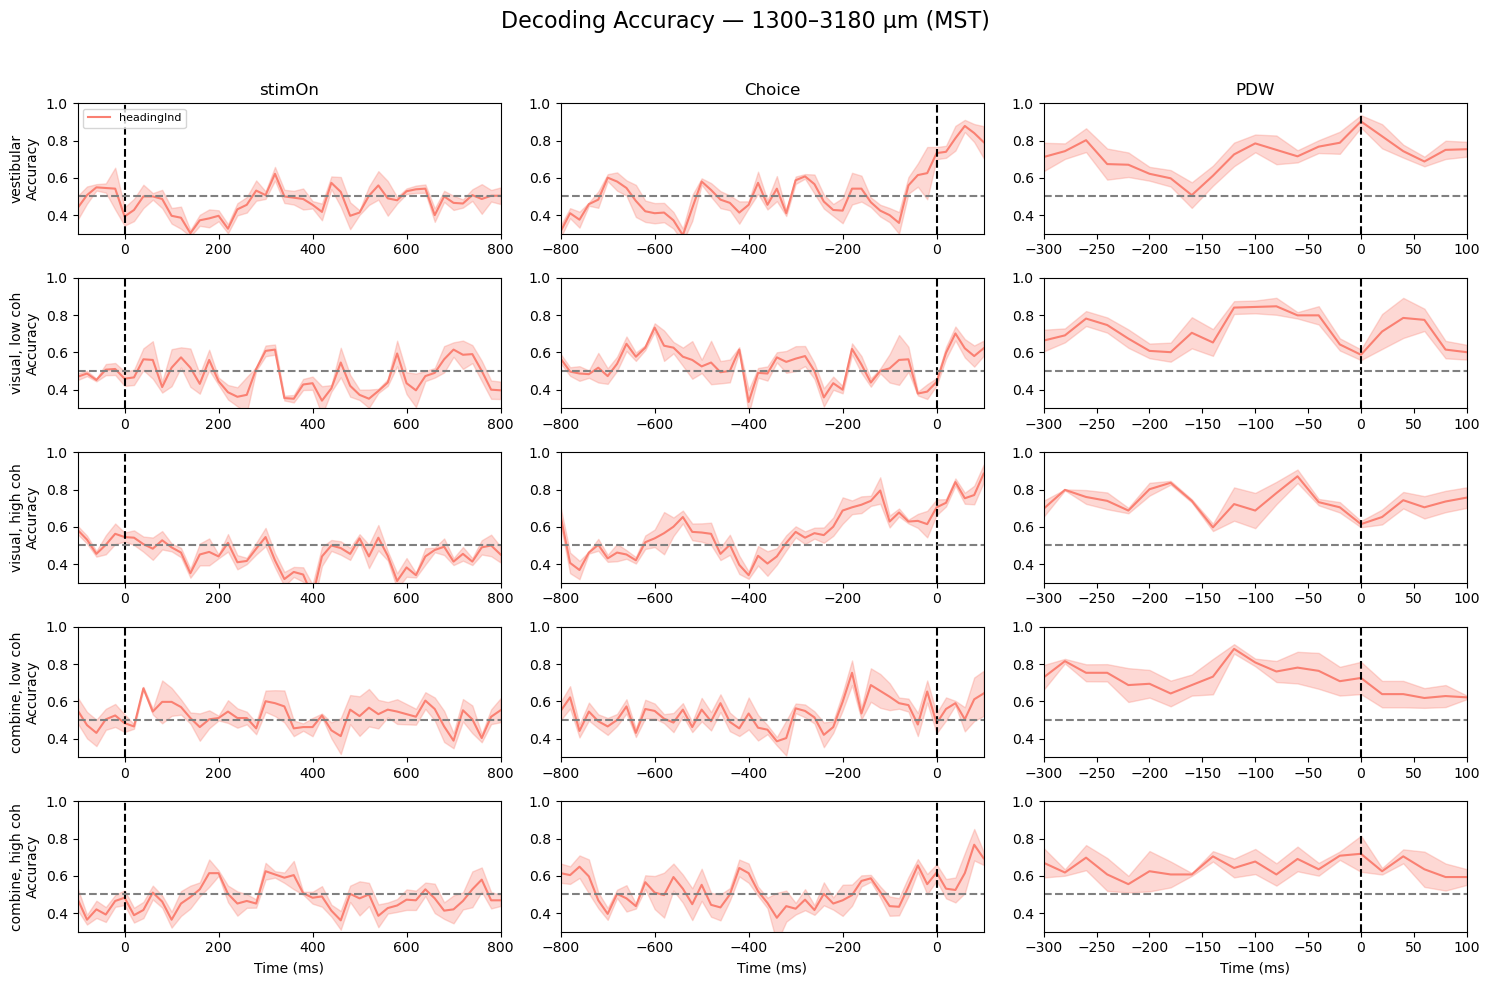

In [176]:
# Plot the decoder accuracy for the choices, headingInd
# PDW latter, you need to balance the trial num
# with PdfPages("20250306_dots3DMP_choiceheadingaccuracyplot.pdf") as pdf:
class_unit = responsive_units
for idx, (depth_min, depth_max) in enumerate(depth_ranges):
    if idx == 0:
        continue

    valid_depth = (depth >= depth_min) & (depth <= depth_max)


    plt.figure(figsize=(15, 10))

    for modcoh in range(5):
        mod = mods[modcoh]
        coh = cohs[modcoh]
        valid_trials = (modality == mod) & (coherence == coh) & np.isin(headingInd, [1, 7])
        valid_trial_indices = np.where(valid_trials)[0]
        print(f"Number of valid trials: {len(valid_trial_indices)}")

        max_splits = 10 
        min_trials_per_split = 3
        n_splits = min(max_splits, len(valid_trial_indices) // min_trials_per_split)

        if n_splits < 2:
            raise ValueError(f"Not enough trials ({len(valid_trial_indices)}) for cross-validation.")
        else:
            print(f"Using n_splits = {n_splits} for cross-validation.")
        
        valid_scores = class_unit[mod - 1, valid_depth.flatten()]
        q75 = np.quantile(valid_scores, 0.75)
        q25 = np.quantile(valid_scores, 0.25)
        responsive_unit = valid_depth.T & (class_unit[mod - 1] >= q75)
        irresponsive_unit = valid_depth.T & (class_unit[mod - 1] <= q25)
        

        
        for valid_unit_mask, linestyle, alpharatio in zip(
            [responsive_unit.T, irresponsive_unit.T],
            ["-", "--"],
            [1, 0.7]
                
        ):
            if alpharatio != 1:
                continue
                
            valid_cluster = np.where(valid_unit_mask)[0]
            print(f"Total valid units under {mod_names[modcoh]}: {len(valid_cluster)}")

            for i in range(3):  # align_event: stim/response/PDW cue
                X = spkrates[i].copy()

                ax = plt.subplot(5, 3, modcoh * 3 + i + 1)

                for d, target_name,condition_name, y,conditioned, color in zip(
                    [0,1],
                    ["choice", "headingInd"],
                    ["headingInd", "choice"],
                    [choice.copy(), headingInd.copy()],
                    [ headingInd.copy(), choice.copy()],
                    ["royalblue", "salmon"]
                    ):

                    if d !=1:
                        continue

                        
                    mean_scores, sem_scores, time_axis = log_decoder(
                        X, y, time_info, valid_trials, valid_cluster,
                        event_info=event_info, target_name=target_name, 
                        align_event=i, num_units=30, n_splits=n_splits, 
                        num_repeats=8, n_shuffles=0
                    )

                    ax.plot(time_axis[:len(mean_scores)], mean_scores, 
                            label=target_name, color=color, linestyle=linestyle, alpha = alpharatio)
                    ax.fill_between(
                        time_axis[:len(mean_scores)],
                        np.array(mean_scores) - np.array(sem_scores),
                        np.array(mean_scores) + np.array(sem_scores),
                        color=color, alpha=0.3 * alpharatio
                    )
                    
#                     ax.plot(time_axis[:len(null_score)], null_score, 
#                             label=target_name, color="gray", linestyle="dotted")
                

                ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
                ax.axhline(0.5, color='gray', linestyle='--', linewidth=1.5)
                ax.set_ylim(0.3, 1)
                ax.set_xlim(time_axis[0], time_axis[-1])

                if modcoh == 0:
                    ax.set_title(event_names[i])
                if modcoh == 4:
                    ax.set_xlabel("Time (ms)")
                if i == 0:
                    ax.set_ylabel(f"{mod_names[modcoh]}\nAccuracy")

                # Only add legend to the last plot of the top row (to avoid clutter)
                if modcoh == 0 and i == 0:
                    ax.legend(loc="upper left", fontsize=8)

    plt.suptitle(f"Decoding Accuracy — {depth_labels[idx]}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
#         pdf.savefig()
#         plt.close()
    plt.show()

In [40]:
print(class_unit.shape)

(0,)


In [8]:
def lin_decoder(X, y, time_info, valid_trials, valid_cluster, heading_angles, dualratio=1, 
                valid_cluster2 = None, align_event=0, num_units=50, n_splits=10,
                 num_repeats=5, shuffle=False, random_state=42):

    # Time info
    center_start = time_info["center_start"][align_event]
    center_stop = time_info["center_stop"][align_event]
    bin_size = time_info["bin_size"]
    time_axis = np.arange(center_start, center_stop + bin_size, bin_size) * 1000  # in ms

    # Valid trial and cluster selection
    selected_trials = ~np.isnan(y).flatten() & valid_trials.flatten()
    X_clean = X[0,0][selected_trials]
    y_clean = y[selected_trials].astype(int)
    
    
    if shuffle:
        rng = np.random.default_rng(random_state)
        y_clean = rng.permutation(y_clean)

    y_clean = heading_angles[y_clean] 
    y_clean = np.sin(np.deg2rad(y_clean))


    num_events, num_units_total = X_clean.shape

    num_time_points = X_clean[0, 0][0].shape[0]
    

    if num_units == 0:
        num_units = len(valid_cluster)
        num_repeats = 1

    all_r2_scores = []
    all_mse_scores = []

    model = Lasso(alpha=0.05)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for rep in range(num_repeats):
        # Random unit selection
        if len(valid_cluster) < num_units:
            raise ValueError(f"Not enough valid units ({len(valid_cluster)}) to sample {num_units}")

        if num_repeats == 1:
            selected_units = valid_cluster
        else:
            selected_cluster = np.random.choice(len(valid_cluster), size=num_units, replace=False)
            selected_units = valid_cluster[selected_cluster]

        X_sub = X_clean[:, selected_units]

        r2_scores = []
        mse_scores = []

        for t in range(num_time_points):
            X_input = np.array([[X_sub[i, j][0][t] for j in range(num_units)] for i in range(len(X_sub))])
            y_input = y_clean

            fold_r2 = []
            fold_mse = []

            for train_idx, test_idx in kf.split(X_input):
                X_train, X_test = X_input[train_idx], X_input[test_idx]
                y_train, y_test = y_input[train_idx], y_input[test_idx]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                fold_r2.append(r2_score(y_test, y_pred))
                fold_mse.append(mean_squared_error(y_test, y_pred))

            r2_scores.append(np.mean(fold_r2))
            mse_scores.append(np.mean(fold_mse))

        all_r2_scores.append(r2_scores)
        all_mse_scores.append(mse_scores)

    # Aggregate results
    mean_r2 = np.mean(all_r2_scores, axis=0)
    sem_r2 = np.std(all_r2_scores, axis=0) / np.sqrt(num_repeats)

    mean_mse = np.mean(all_mse_scores, axis=0)
    sem_mse = np.std(all_mse_scores, axis=0) / np.sqrt(num_repeats)

    return mean_mse, sem_mse, time_axis

In [ ]:
# Plot the decoder accuracy for the heading
with PdfPages("20250306_dots3DMP_choicevsheadingplot.pdf") as pdf:
    for idx, (depth_min, depth_max) in enumerate(depth_ranges):

            
        valid_depth = (depth >= depth_min) & (depth <= depth_max)
        valid_cluster = cluster_id[valid_depth]

        plt.figure(figsize=(15, 10))
        y_heading = headingInd.flatten() - 1
        
        
        for modcoh in range(5):
            
            mod = mods[modcoh]
            coh = cohs[modcoh]
                
            valid_trials = (modality == mod) & (coherence == coh)

            for i in range(3):
                X = spkrates[i].copy()

                mean_scores_heading, sem_scores_heading, time_axis = lin_decoder(
                    X, y_heading, time_info, valid_trials, valid_cluster, 
                    heading_angles = heading_angles,
                    align_event=i, num_units = 50, n_splits=10,
                    num_repeats=5
                )
                shuffled_mean, shuffled_sem, time_axis = lin_decoder(
                    X, y_heading, time_info, valid_trials, valid_cluster, 
                    heading_angles = heading_angles,
                    align_event=i, num_units = 50, n_splits=10,
                    num_repeats=5, shuffle = True
                )
        
        
                # Plot choice decoding (blue)
                ax = plt.subplot(5, 3, modcoh * 3 + i + 1)
                
                # Plot heading decoding (red)
                ax.plot(time_axis[:len(mean_scores_heading)], mean_scores_heading, color='red')
                ax.fill_between(
                    time_axis[:len(mean_scores_heading)],
                    np.array(mean_scores_heading) - np.array(sem_scores_heading),
                    np.array(mean_scores_heading) + np.array(sem_scores_heading),
                    color='salmon', alpha=0.5
                )
                
                # Plot suffled decoding (grayd)
                ax.plot(time_axis[:len(shuffled_mean)], shuffled_mean, color='gray', linestyle='--')
                ax.fill_between(
                    time_axis[:len(shuffled_mean)],
                    np.array(shuffled_mean) - np.array(shuffled_sem),
                    np.array(shuffled_mean) + np.array(shuffled_sem),
                    color='lightblue', alpha=0.5
                )

                ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
                ax.set_ylim(0.008, 0.012)
                ax.set_xlim(time_axis[0], time_axis[-1])

                if modcoh == 0:
                    ax.set_title(event_names[i])
                if modcoh == 4:
                    ax.set_xlabel("Time (ms)")
                if i == 0:
                    ax.set_ylabel(f"{mod_names[modcoh]}\nAccuracy")

        plt.suptitle(f"Decoding Accuracy — {depth_labels[idx]}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig()
        plt.close()
#         plt.show()


In [ ]:
# Plot the decoder accuracy tuning
# with PdfPages("20250501_dots3DMP_tunningdecoMSEplot.pdf") as pdf:
for idx, (depth_min, depth_max) in enumerate(depth_ranges):

#         if idx != 2:
#             continue

    valid_depth = (depth >= depth_min) & (depth <= depth_max)
    valid_cluster = cluster_id[valid_depth]
    # Time info
    center_start = tunning_info["center_start"]
    center_stop = tunning_info["center_stop"]
    bin_size = tunning_info["bin_size"]

    plt.figure(figsize=(15, 10))


    for mod in range(3):

        valid_trials = (modality == mod+1)


        for i in range(1):
            X = data_spkrate.copy()
            y_heading = headingInd.flatten() - 1

            num_time_points = 164
            time_axis_heading = np.arange(center_start, center_start + bin_size * num_time_points, bin_size) * 1000  # in ms



            mean_scores_heading, sem_scores_heading, time_axis = lin_decoder(
                X, y_heading, time_info, valid_trials, valid_cluster, 
                heading_angles = tuning_angles,
                align_event=i, num_units = 50, n_splits=10,
                num_repeats=3
            )
            shuffled_mean, shuffled_sem, time_axis = lin_decoder(
                X, y_heading, time_info, valid_trials, valid_cluster, 
                heading_angles = tuning_angles,
                align_event=i, num_units = 50, n_splits=10,
                num_repeats=3, shuffle = True
            )


            # Plot heading decoding (red)
            ax = plt.subplot(3, 1, mod + 1)
            ax.plot(time_axis_heading[:len(mean_scores_heading)], mean_scores_heading, color='red')
            ax.fill_between(
                time_axis_heading[:len(mean_scores_heading)],
                np.array(mean_scores_heading) - np.array(sem_scores_heading),
                np.array(mean_scores_heading) + np.array(sem_scores_heading),
                color='salmon', alpha=0.5
            )
            ax.plot(time_axis_heading[:len(shuffled_mean)], shuffled_mean, color='gray', linestyle='--')
            ax.fill_between(
                time_axis_heading[:len(shuffled_mean)],
                np.array(shuffled_mean) - np.array(shuffled_sem),
                np.array(shuffled_mean) + np.array(shuffled_sem),
                color='lightblue', alpha=0.5
            )

            ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
            ax.axvline(2300, color='black', linestyle='--', linewidth=1.5)
            ax.set_ylim(0.06, 0.24)
#                 ax.set_xlim(time_axis_choice[0], time_axis_choice[-1])
            ax.set_xlim(time_axis_heading[0], time_axis_heading[-1])

            if mod == 0:
                ax.set_title("linear regression for heading angle in 3DMPtunning")
            if mod == 2:
                ax.set_xlabel("Time (ms)")
            if i == 0:
                mod_names = ["vestibular", "visual", "combine"]
                ax.set_ylabel(f"{mod_names[mod]}\nAccuracy")

    plt.suptitle(f"Decoding Accuracy — {depth_labels[idx]}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
#     pdf.savefig()
#     plt.close()
        plt.show()


In [4]:
print(unit_mask_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
